Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-resnet18-mnist.ipynb)

## Code Modules, Classes, & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,urllib,zipfile
from torchvision.datasets import MNIST as tmnist
from torchvision import transforms
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
from torch.utils.data.dataset import Subset
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [2]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
def display_examples(data_loader,img_size):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size),
                      cmap=pl.cm.bone)
        break

In [4]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [5]:
random_seed=12; batch_size=128
tr0=(.5); tr1=(.25); img_size=28
trans=transforms\
.Compose([transforms.Resize((img_size,img_size)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr1)])
train_ids=torch.arange(0,54000)
valid_ids=torch.arange(54000,60000)
train_valid=tmnist(root='data',train=True,
                   download=True,transform=trans)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tmnist(root='data',train=False, 
            transform=trans)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.




Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])




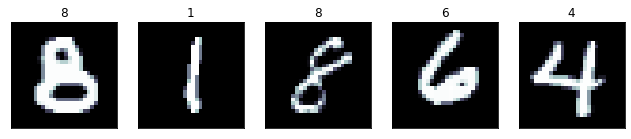

In [6]:
display_examples(valid_loader,img_size)

In [7]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=1-np.array(f[keys[1]],dtype='float32')/255
x=timage.resize(x,[img_size,img_size])
x=(np.dot(x.numpy(),[.299,.587,.114]))\
.reshape(-1,1,img_size,img_size)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

['backgrounds', 'images', 'labels']


In [8]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,shuffle=True,
                  batch_size=batch_size2)
valid_loader2=tdl(dataset=valid2,shuffle=True,
                  batch_size=batch_size2)
test_loader2=tdl(dataset=test2,shuffle=False,
                 batch_size=batch_size2)

Image dimensions: torch.Size([128, 1, 28, 28])
Label dimensions: torch.Size([128])


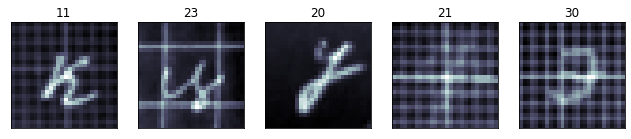

In [9]:
display_examples(valid_loader2,img_size)

## ResNet

In [10]:
def conv3x3(in_planes,out_planes,stride=1):
    return tnn.Conv2d(in_planes,out_planes,
                      kernel_size=3,stride=stride,
                      padding=1,bias=False)
class BasicBlock(tnn.Module):
    expansion=1
    def __init__(self,inplanes,planes,
                 stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1=conv3x3(inplanes,planes,stride)
        self.bn1=tnn.BatchNorm2d(planes)
        self.relu=tnn.ReLU(inplace=True)
        self.conv2=conv3x3(planes,planes)
        self.bn2=tnn.BatchNorm2d(planes)
        self.downsample=downsample
        self.stride=stride
    def forward(self,x):
        residual=x
        y=self.conv1(x); y=self.bn1(y)
        y=self.relu(y)
        y=self.conv2(y); y=self.bn2(y)
        if self.downsample is not None:
            residual=self.downsample(x)
        y+=residual
        y=self.relu(y)
        return y

In [11]:
class ResNet(tnn.Module):
    def __init__(self,block,layers,num_classes,grayscale):
        self.inplanes=64
        if grayscale: in_dim=1
        else: in_dim=3
        super(ResNet,self).__init__()
        self.conv1=tnn\
        .Conv2d(in_dim,64,kernel_size=7,stride=2,
                padding=3,bias=False)
        self.bn1=tnn.BatchNorm2d(64)
        self.relu=tnn.ReLU(inplace=True)
        self.maxpool=tnn\
        .MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,64,layers[0])
        self.layer2=self._make_layer(block,128,
                                     layers[1],stride=2)
        self.layer3=self._make_layer(block,256,
                                     layers[2],stride=2)
        self.layer4=self._make_layer(block,512,
                                     layers[3],stride=2)
        self.avgpool=tnn.AvgPool2d(7,stride=1)
        self.fc=tnn.Linear(512*block.expansion,num_classes)
        for m in self.modules():
            if isinstance(m,tnn.Conv2d):
                n=m.kernel_size[0]*m.kernel_size[1]*m.out_channels
                m.weight.data.normal_(0,(2./n)**.5)
            elif isinstance(m,tnn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def _make_layer(self,block,planes,blocks,stride=1):
        downsample=None
        if stride!=1 or self.inplanes!=planes*block.expansion:
            downsample=tnn.Sequential(
                tnn.Conv2d(self.inplanes,planes*block.expansion,
                           kernel_size=1,stride=stride,bias=False),
                tnn.BatchNorm2d(planes*block.expansion))
        layers=[]
        layers.append(block(self.inplanes,planes,
                            stride,downsample))
        self.inplanes=planes*block.expansion
        for i in range(1,blocks):
            layers.append(block(self.inplanes,planes))
        return tnn.Sequential(*layers)
    def forward(self,x):
        x=self.conv1(x); x=self.bn1(x)
        x=self.relu(x); x=self.maxpool(x)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
#        x=self.avgpool(x)        
        x=x.view(x.size(0),-1)
        logits=self.fc(x)
        probs=tnnf.softmax(logits,dim=1)
        return logits,probs
def ResNN(num_classes):
    model=ResNet(block=BasicBlock,layers=[2,2,2,2],
                num_classes=num_classes,
                grayscale=True)
    return model

## Training

In [12]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%200:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))

In [13]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.001
model=ResNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [14]:
%train_run 50

Epoch: 001/050 | Batch 000/421 | Cost: 2.5748
Epoch: 001/050 | Batch 200/421 | Cost: 0.0244
Epoch: 001/050 | Batch 400/421 | Cost: 0.0940
Epoch: 001/050 train acc: 98.01% valid acc: 98.13%
Epoch: 002/050 | Batch 000/421 | Cost: 0.0327
Epoch: 002/050 | Batch 200/421 | Cost: 0.1296
Epoch: 002/050 | Batch 400/421 | Cost: 0.0410
Epoch: 002/050 train acc: 98.60% valid acc: 98.55%
Epoch: 003/050 | Batch 000/421 | Cost: 0.0612
Epoch: 003/050 | Batch 200/421 | Cost: 0.0249
Epoch: 003/050 | Batch 400/421 | Cost: 0.0339
Epoch: 003/050 train acc: 99.07% valid acc: 98.67%
Epoch: 004/050 | Batch 000/421 | Cost: 0.0206
Epoch: 004/050 | Batch 200/421 | Cost: 0.0885
Epoch: 004/050 | Batch 400/421 | Cost: 0.0050
Epoch: 004/050 train acc: 99.01% valid acc: 98.78%
Epoch: 005/050 | Batch 000/421 | Cost: 0.0079
Epoch: 005/050 | Batch 200/421 | Cost: 0.1009
Epoch: 005/050 | Batch 400/421 | Cost: 0.0096
Epoch: 005/050 train acc: 99.00% valid acc: 98.65%
Epoch: 006/050 | Batch 000/421 | Cost: 0.0538
Epoch: 00

In [15]:
%print_acc 1

Train accuracy: 99.8722%
Valid accuracy: 99.1167%
Test accuracy: 99.3200%


In [19]:
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer2.zero_grad(); cost.backward()
            optimizer2.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))

In [22]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.001
model=ResNN(num_classes)
model.to(dev)
optimizer2=torch.optim.Adam(model.parameters(),
                            lr=learning_rate)

In [23]:
%train_run2 70

Epoch: 001/070 | Batch 000/088 | Cost: 3.6754
Epoch: 001/070 | Batch 050/088 | Cost: 2.3808
Epoch: 001/070 train acc: 19.85% valid acc: 19.38%
Epoch: 002/070 | Batch 000/088 | Cost: 1.6914
Epoch: 002/070 | Batch 050/088 | Cost: 1.0396
Epoch: 002/070 train acc: 55.36% valid acc: 52.22%
Epoch: 003/070 | Batch 000/088 | Cost: 0.9967
Epoch: 003/070 | Batch 050/088 | Cost: 0.8848
Epoch: 003/070 train acc: 67.96% valid acc: 63.21%
Epoch: 004/070 | Batch 000/088 | Cost: 0.5888
Epoch: 004/070 | Batch 050/088 | Cost: 0.4424
Epoch: 004/070 train acc: 56.21% valid acc: 54.40%
Epoch: 005/070 | Batch 000/088 | Cost: 0.5117
Epoch: 005/070 | Batch 050/088 | Cost: 0.4103
Epoch: 005/070 train acc: 72.00% valid acc: 66.31%
Epoch: 006/070 | Batch 000/088 | Cost: 0.5529
Epoch: 006/070 | Batch 050/088 | Cost: 0.5207
Epoch: 006/070 train acc: 80.53% valid acc: 74.14%
Epoch: 007/070 | Batch 000/088 | Cost: 0.6004
Epoch: 007/070 | Batch 050/088 | Cost: 0.2522
Epoch: 007/070 train acc: 86.19% valid acc: 77.10%

In [24]:
%print_acc 2

Train accuracy: 98.9341%
Valid accuracy: 87.5264%
Test accuracy: 90.0634%
